In [18]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import time
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['WANDB_DISABLE_CODE'] = 'True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [3]:
train_ds, validation_ds = tfds.load('tf_flowers', split=['train[:85%]', 'train[85%:]'], as_supervised=True)

2023-09-23 11:57:39.648377: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


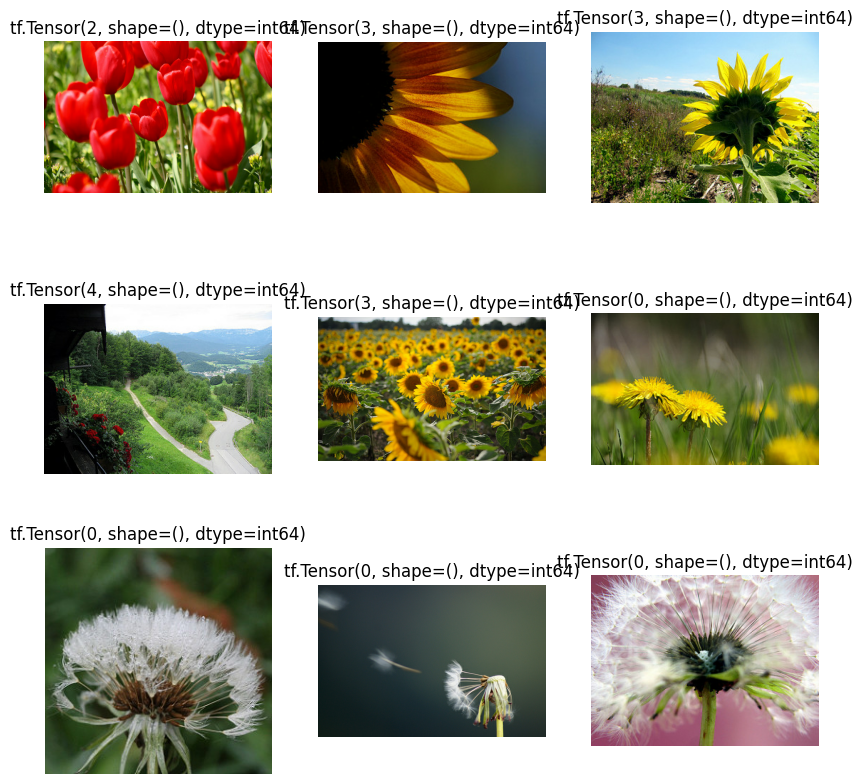

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")

In [5]:
IMG_SHAPE, BATCH_SIZE, AUTO = 128, 64, tf.data.experimental.AUTOTUNE

@tf.function
def custom_augment(image, label):
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    image = random_apply(color_jitter, image, p=0.4)
    image = random_apply(color_drop, image, p=0.2)

    return image, label

@tf.function
def color_jitter(x, s=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), tf.cast(p, tf.float32)),
                    lambda: func(x), lambda: x)

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return image, label

In [6]:
train_ds = (train_ds.map(preprocess_image, num_parallel_calls=AUTO)
           .shuffle(100).map(custom_augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

2023-09-22 21:22:06.192030: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


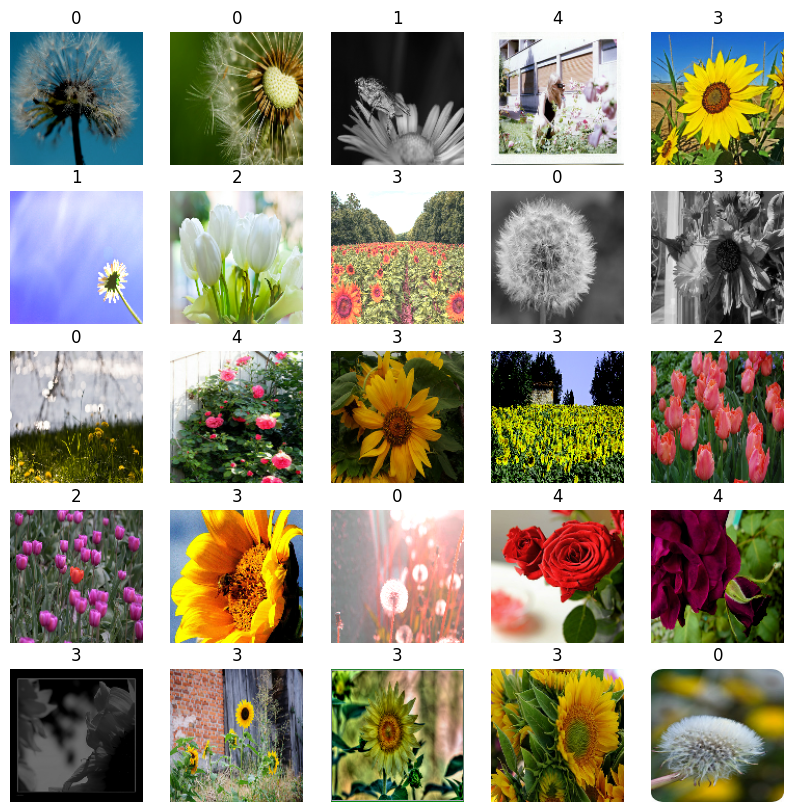

In [12]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis('off')

## Model building

In [10]:
class UnitNormLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [13]:
def encoder_net():
    inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
    normalization_layer = UnitNormLayer()
    
    encoder = tf.keras.applications.ResNet50(include_top=False, weights=None)
    encoder.trainable = True
    
    embeddings = encoder(inputs, training=True)
    embeddings = tf.keras.layers.GlobalAveragePooling2D()(embeddings)
    norm_embeddings = normalization_layer(embeddings)
    encoder_network = tf.keras.Model(inputs, norm_embeddings)
    
    return encoder_network

def projector_net():
    projector = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        UnitNormLayer()
    ])
    return projector

In [19]:
encoder = encoder_net()
projector = projector_net()

images, _ = next(iter(train_ds))
r = encoder(tf.expand_dims(images[0], 0))
z = projector(r)

print(tf.shape(r), tf.shape(z))

tf.Tensor([   1 2048], shape=(2,), dtype=int32) tf.Tensor([  1 128], shape=(2,), dtype=int32)


2023-09-23 12:12:08.179324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
